In [1]:
import qutip as qt
from qutip_qip.operations.gates import hadamard_transform as hadamard

import numpy as np
from matplotlib import pyplot as plt

import jax
import jax.numpy as jnp
from diffrax import Dopri5, PIDController, Dopri8

from optimize import optimize_pulses
from time_interval import TimeInterval
from objective import Objective

# Quantum Optimal Control Task

\begin{gather*}
    X(t=0) \underset{H}{\longrightarrow} X_\mathrm{trgt}=X(t=T)
\end{gather*}

\begin{gather}
    \partial_{t} X(t) = - \mathrm i \underbrace{\left( A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k \right)}_{H} X(t)
\end{gather}

Closed system

\begin{array}{c|c|c|c}
 & \text{drift } A        & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}  &  H_d         &  B_k& |\Psi(t, \alpha)>\\
 \text{gate synthesis}       &  H_d         &  B_k & U(t, \alpha)   \\\hline
 \text{state transfer}      &  \hat H_d    &  \hat B_k & \rho(t, \alpha) \\
 \text{gate synthesis}     &  \hat H_d    &  \hat B_k & \hat{U}(t, \alpha)
\end{array}

\begin{gather*}
    g = \frac{1}{\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[X_\mathrm{trgt}^{\dagger} X(T, \alpha) \right]
\end{gather*}

\begin{gather*}
    f_\mathrm{SU} = \mathrm{Re}(g) \text{ and } f_\mathrm{PSU} = |g|
\end{gather*}

Open system

\begin{array}{c|c|c|c}
  & \text{drift } A   & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}     &  \hat H_d +
 \mathrm i \hat{L}    &  \hat B_k& \rho(t, \alpha) \\
 \text{map synthesis}         &   \hat H_d + \mathrm i \hat L    &  \hat B_k& \hat{U}(t, \alpha)\\
\end{array}

\begin{gather*}
    d = \frac{1}{2\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[ (X(T, \alpha) - X_\mathrm{trgt})^\dagger  (X(T, \alpha) - X_\mathrm{trgt})\right]
\end{gather*}

\begin{gather*}
    f_\mathrm{TRCDFF} = \mathrm{Re}(d)
\end{gather*}

---
# GRadient Ascent Pulse Engineering (GRAPE)
---

Slice time interval $T$ in $M$ chunks of size $\Delta t$, with piecewise constant functions $c_j(t_i, \vec \alpha) = \mathrm{const.}$ for $i \in [1, M]$

\begin{gather*}
H(t_i, \alpha) \approx A + \sum_{k=0}^{C-1} \alpha_{i,k} B_k \\

X(t_i, \alpha) = \underbrace{X_i}_{\exp(-\mathrm i H(t_i, \alpha) \Delta t)}
X_{i-1} \dots X_1 X_0
\end{gather*}

update parameters according to $\frac{\partial f^{(r)}(X(t, \alpha))}{\partial \alpha_{i,k}}$

<img src="doc_images\DYNAMO.png" alt="dynamo" width="600"/>

---
# Chopped RAndom Basis (CRAB)
---

Update initial guess controls $c^{\text{ init}}_k(t, \vec \alpha_k)$ through parameterized update function $g_k(t, \vec \beta_k)$ expanded in some function basis i.e. Fourier:

\begin{align*}
    c^{\text{ update}}_k(t, \vec \alpha_k) &= c^{\text{ init}}_k(t, \vec \alpha_k) \cdot g_k(t, \vec \beta_k) \\ \\
    &= c^{\text{ init}}_k(t, \vec \alpha_k) \left( 1 +
    \sum_{l=1}^{\infty} A_l \sin ( \omega_l t) + B_l \cos ( \omega_l t) \right)
\end{align*}

fix + randomly choose $\omega_l$ and chop to finite basis $l\in[1, L]$

<img src="doc_images\CRAB.png" alt="crab" width="800"/>

---
# Gradient Optimization of Analytic conTrols (GOAT)
---

\begin{align}
    \mathrm i\partial_{t} X = & \phantom{xx} H X\\
    \mathrm i\partial_{\alpha}\partial_{t} X = &\partial_{\alpha}  H X
\end{align}

\begin{gather*}
   {\overset{\text{RHS}}{\longrightarrow}} \begin{pmatrix}
        H & 0 \\
        \partial_{{\alpha}}{H}& H \\
    \end{pmatrix}
    \begin{pmatrix}
        X \\
        \partial_{{\alpha}}{X} \\
    \end{pmatrix}
    = \begin{pmatrix}
        H X \\
        (\partial_{{\alpha}}{H}) X + H (\partial_{{\alpha}}{X}) \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        H & 0 & 0 & 0\\
        \partial_{\vec{\alpha}_0}{H}& H & 0 & 0 \\
        \partial_{\vec{\alpha}_1}{H}& 0 & H & 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
     \begin{pmatrix}
        X \\
        \partial_{\vec{\alpha}_0}{X} \\
        \partial_{\vec{\alpha}_1}{X} \\
        \vdots \\
    \end{pmatrix}
    \\ \\ 
\end{gather*}




Algebra ...

\begin{gather*}
   =
    \begin{pmatrix}
        A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)& A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        A & 0 & 0 & 0\\
        0& A & 0 & 0 \\
        0& 0 & A & 0 \\
        0 & 0 & 0 & \ddots \\
    \end{pmatrix}
    +\sum_{k=0}^{C-1}
    \begin{pmatrix}
        c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)&  c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    
    
\end{gather*}

\begin{gather*} =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \begin{pmatrix}
        0 & 0 &  \\
        B_0\, \partial_{\vec{\alpha}_0} c_0(\vec{\alpha}_0, t)& 0 & \\
        B_1\,\partial_{\vec{\alpha}_1} c_1(\vec{\alpha}_1, t)& 0  & \\
        \vdots &  & \ddots \\
    \end{pmatrix}
    \\ \\ =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \sum_{k=0}^{C-1} (\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k}} c_k(\vec{\alpha}_k, t)
\end{gather*}

Details ...
where $\mathbf{1}_{0,k+1}$ is the zero square matrix with only one entry in the first column at row index $1 + (k \cdot M + l)$ set to one, and ($l$ index of) $M$

is the number of varaible parameters for each control amplitude $c_k(\vec{\alpha}_k, t)$, i.e. for a superposition of Gaussian pulses with three variable parameters each $\rightarrow M = 3 \cdot m$:
\begin{gather*}
    c_k(\vec{\alpha}_k, t) = \sum_{l=0}^{M-1} A_{k,l} \exp\left({\frac{-(t-\tau_{k,l})^2}{\sigma_{k,l}^2}}\right)
\end{gather*}

Expressing the Hamiltonian in this form makes it comfortable to implement it using QuTiP
\begin{gather*}
    \underbrace{(\mathbf{I} \otimes A)}_{\mathrm{QobjEvo(}\tilde{H}_d,f(x)=1)}
     + \sum_{k=0}^{C-1}\underbrace{(\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,c_k(\vec{\alpha}_k, t))}
     + \sum_{k=0}^{C-1} \sum_{l=0}^{M-1} \underbrace{(\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,\partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t))}
\end{gather*}

Complexity ...

We have now $1 + C + C \cdot M = O(C \cdot M)$ summands, i.e. the term grows linear with the number of parameters $N_{\mathrm{para}} = C \cdot M$

The size of the matrix however grows with $O(N_{\mathrm{para}} \cdot \mathrm{dim}(A))$

---
# Example: Hadamard Gate (two level system)
---

\begin{gather*}
    X(t=0) = \mathbf{I} \longrightarrow X(T) = \mathrm{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{gather*}

In [2]:
initial = qt.qeye(2)
target = hadamard()

initial = qt.sprepost(initial, initial.dag())
target = qt.sprepost(target, target.dag())

\begin{gather}
    \partial_{t} X(t) =-\frac{i}{\hbar}[H(\vec{\alpha}, t), X(t)]+ \frac{1}{2} \left[2 C X(t) C^\dagger - X(t) C^\dagger C - C^\dagger C X(t)\right] \\
\end{gather}

\begin{gather*}
    H(\vec{\alpha}, t) = \underbrace{
            \frac{1}{2} \left(\omega \sigma_z +  \Delta \sigma_x\right)
        }_{H_d} 
    + H_c(\vec{\alpha}, t) \text{ and }C = \sqrt \gamma a
\end{gather*}

Time independent drift Hamiltonian

In [3]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

# energy splitting, tunneling, amplitude damping
ω, Δ, γ = 0.1, 1.0, 0.1

Hd = 1 / 2 * (ω * σz + Δ * σx)

H_d = qt.liouvillian(H=Hd, c_ops=[np.sqrt(γ) * qt.sigmam()])

In [4]:
π = np.pi
num_ts = 100
interval = TimeInterval(evo_time=2 * π, n_tslots=num_ts)

In [5]:
Hc = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

init_x = np.ones(num_ts)
init_y = np.ones(num_ts)
init_z = np.ones(num_ts)

H = [H_d,
     [H_c[0], init_x],
     [H_c[1], init_y],
     [H_c[2], init_z]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.01s. Est. time left: 00:00:00:00
80.8%. Run time:   0.01s. Est. time left: 00:00:00:00
90.9%. Run time:   0.01s. Est. time left: 00:00:00:00
100.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

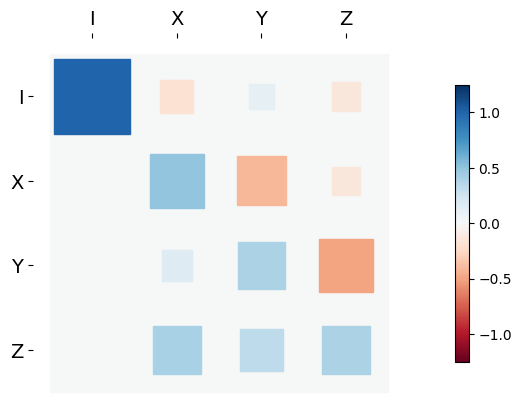

In [6]:
init_evo = qt.mesolve(H, initial, interval.tslots)

qt.hinton(init_evo.final_state)

# QuTiP GRAPE

<img src="doc_images\QOC.png" alt="qoc" width="600"/>

In [7]:
res_grape = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess": init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess": init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess": init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "GRAPE",
        "fid_err_targ": 0.01,
        "max_iter": 1000,
    },
)

{}


In [8]:
res_grape

Control Optimization Result
       --------------------------
       - Started at 2023-11-17 15:53:54
       - Number of objectives: 1
       - Final fidelity error: 0.04392156490288248
       - Final parameters: [[ 7.44219311e-01  2.66722506e-01  5.54102894e-01  7.06476028e-01
  4.13729506e-01 -1.44754406e-01  8.67308515e-01  1.00000000e+00
  9.52810520e-01  7.26982852e-01  9.51797711e-01  3.18640407e-02
  9.36360342e-01  9.99240407e-01  9.82866501e-01  5.74769059e-01
  1.85339909e-01  5.00984164e-01 -2.20790472e-01  5.68774509e-03
  7.23741608e-01 -2.25380243e-01  5.94856221e-01  6.92090644e-01
  2.34550757e-01  3.22985067e-02  6.82328770e-01 -1.95453176e-01
  7.06422879e-01  4.30412037e-01  7.41395922e-01  5.03190944e-01
 -9.02186570e-02  4.07142692e-02  9.84651277e-01  4.64274532e-01
  1.00000000e+00  1.28892758e-01  7.81292442e-01  9.90231628e-01
  9.97305680e-01  3.57935039e-01  1.00000000e+00  1.00000000e+00
  9.46543915e-01  8.62850605e-01  6.80478000e-01  3.51761173e-01
  4.74

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

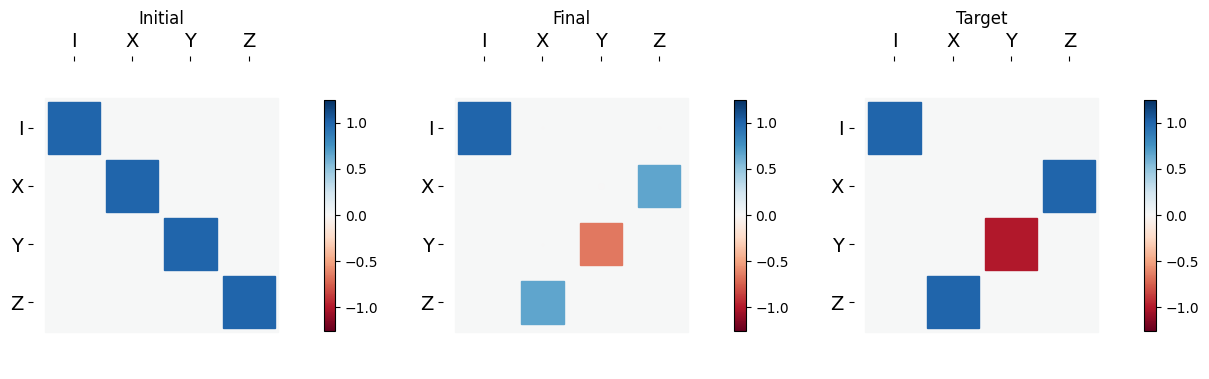

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_grape.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

# QuTiP CRAB

In [10]:
res_crab = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess": init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess": init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess": init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "CRAB",  # new
        "fid_err_targ": 0.01,
    }
)

{}


In [11]:
res_crab

Control Optimization Result
       --------------------------
       - Started at 2023-11-17 15:54:00
       - Number of objectives: 1
       - Final fidelity error: 0.04425595033422666
       - Final parameters: [[ 5.24024666e-01  5.23236281e-01  5.18510852e-01  5.11472153e-01
  5.03833298e-01  4.97371358e-01  4.93856437e-01  4.94941374e-01
  5.02024876e-01  5.16104726e-01  5.37640195e-01  5.66446365e-01
  6.01648332e-01  6.41725459e-01  6.84666327e-01  7.28227357e-01
  7.70248267e-01  8.08946091e-01  8.43109684e-01  8.72153317e-01
  8.96040842e-01  9.15131051e-01  9.30003990e-01  9.41312155e-01
  9.49675866e-01  9.55622078e-01  9.59555300e-01  9.61746702e-01
  9.62328954e-01  9.61286872e-01  9.58435659e-01  9.53379026e-01
  9.45439063e-01  9.33549972e-01  9.16112069e-01  8.90817939e-01
  8.54501013e-01  8.03130926e-01  7.32182602e-01  6.37660810e-01
  5.17878065e-01  3.75473518e-01  2.18380137e-01  5.84792421e-02
 -9.18060116e-02 -2.22981248e-01 -3.30076732e-01 -4.12116166e-01
 -4.70

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

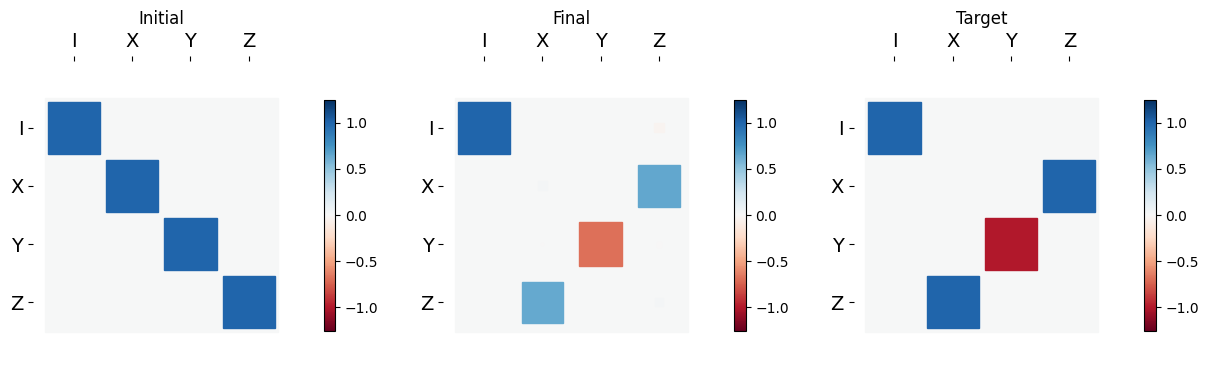

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_crab.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

In [13]:
def plot_result(
    res,
    title,
    y_labels=[
        "$\\sigma_x$",
        "$\\sigma_y$",
        "$\\sigma_z$"]):

    fig, ax = plt.subplots(len(res.optimized_controls),
                           1, figsize=(15, 12), sharex=True)

    ax[0].set_title(title, fontsize=20)


    for i in range(len(res.optimized_controls)):

        ax[i].xaxis.set_label_text('Time')

        ax[i].yaxis.set_label_text('Control ' + y_labels[i])

        ax[i].plot(
            res.time_interval.tslots,
            res.guess_controls[i],
            label='Guess')

        ax[i].plot(
            res.time_interval.tslots,
            res.optimized_controls[i],
            label='Optimized')

        ax[i].legend()

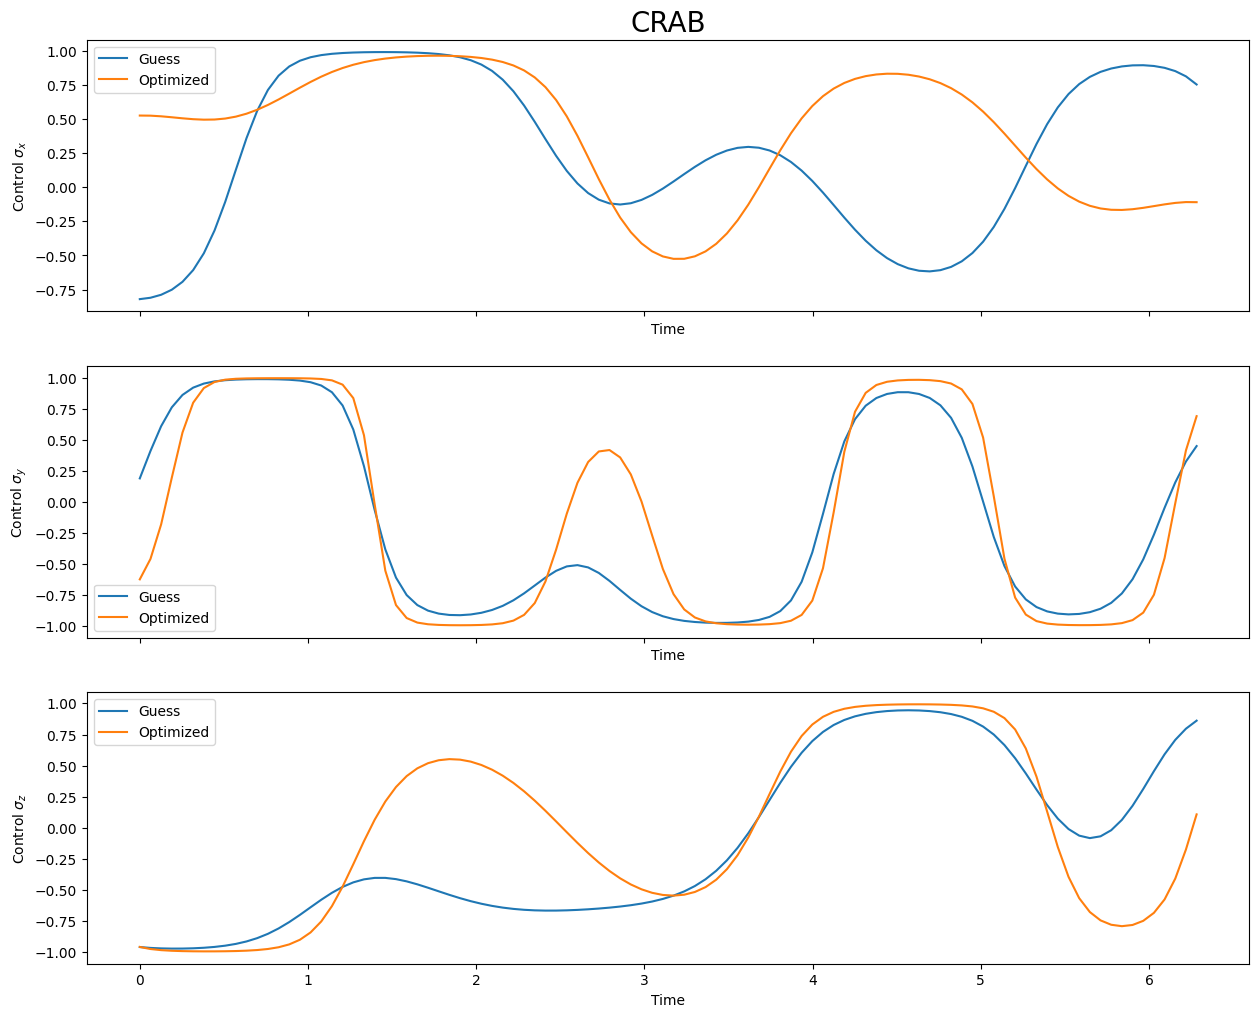

In [14]:
plot_result(res_crab, "CRAB")

# QuTiP GOAT

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [15]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])


def grad_sin(t, α, idx):
    if idx == 0:
        return np.sin(α[1] * t + α[2])
    if idx == 1:
        return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx == 2:
        return α[0] * np.cos(α[1] * t + α[2])
    if idx == 3:
        return α[0] * np.cos(α[1] * t + α[2]) * α[1]  # w.r.t. time

In [16]:
def sin_x(t, p): return sin(t, p)
def sin_y(t, q): return sin(t, q)


def sin_z(t, r): return sin(t, r)

In [17]:
H = [H_d,
     [H_c[0], sin_x, {"grad": grad_sin}],
     [H_c[1], sin_y, {"grad": grad_sin}],
     [H_c[2], sin_z, {"grad": grad_sin}]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.01s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.02s. Est. time left: 00:00:00:00
70.7%. Run time:   0.02s. Est. time left: 00:00:00:00
80.8%. Run time:   0.03s. Est. time left: 00:00:00:00
90.9%. Run time:   0.03s. Est. time left: 00:00:00:00
100.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.04s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

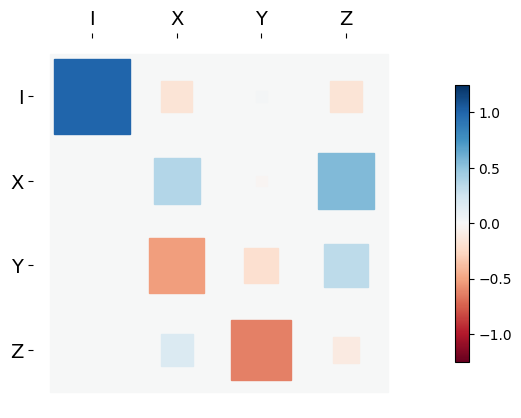

In [18]:
p_init = [1, 1, 0]  # amplitude, frequency, phase
q_init = [1, 1, 0]  # q[0] * sin(q[1] * t + q[2])
r_init = [1, 1, 0]

init_evo = qt.mesolve(H, initial, interval.tslots,
                      options={'normalize_output': False},
                      args={"p": p_init, "q": q_init, "r": r_init})

qt.hinton(init_evo.final_state)

<img src="doc_images\QOC.png" alt="crab" width="600"/>

In [19]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "GOAT",  # new
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={  # new
        "max_iter": 0,
        "seed": 1,
    },
)

{}


In [20]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-17 15:54:08
- Number of objectives: 1
- Final fidelity error: 0.04403656960277009
- Final parameters: [[1.0, 0.6462771162438175, 2.1425609700529074], [0.9996894160117288, 0.990898249375864, 0.004499661412899851], [0.8444724950457054, 2.379880939421669e-09, 0.2993300539999815]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-17 15:54:12 (3.9596s)

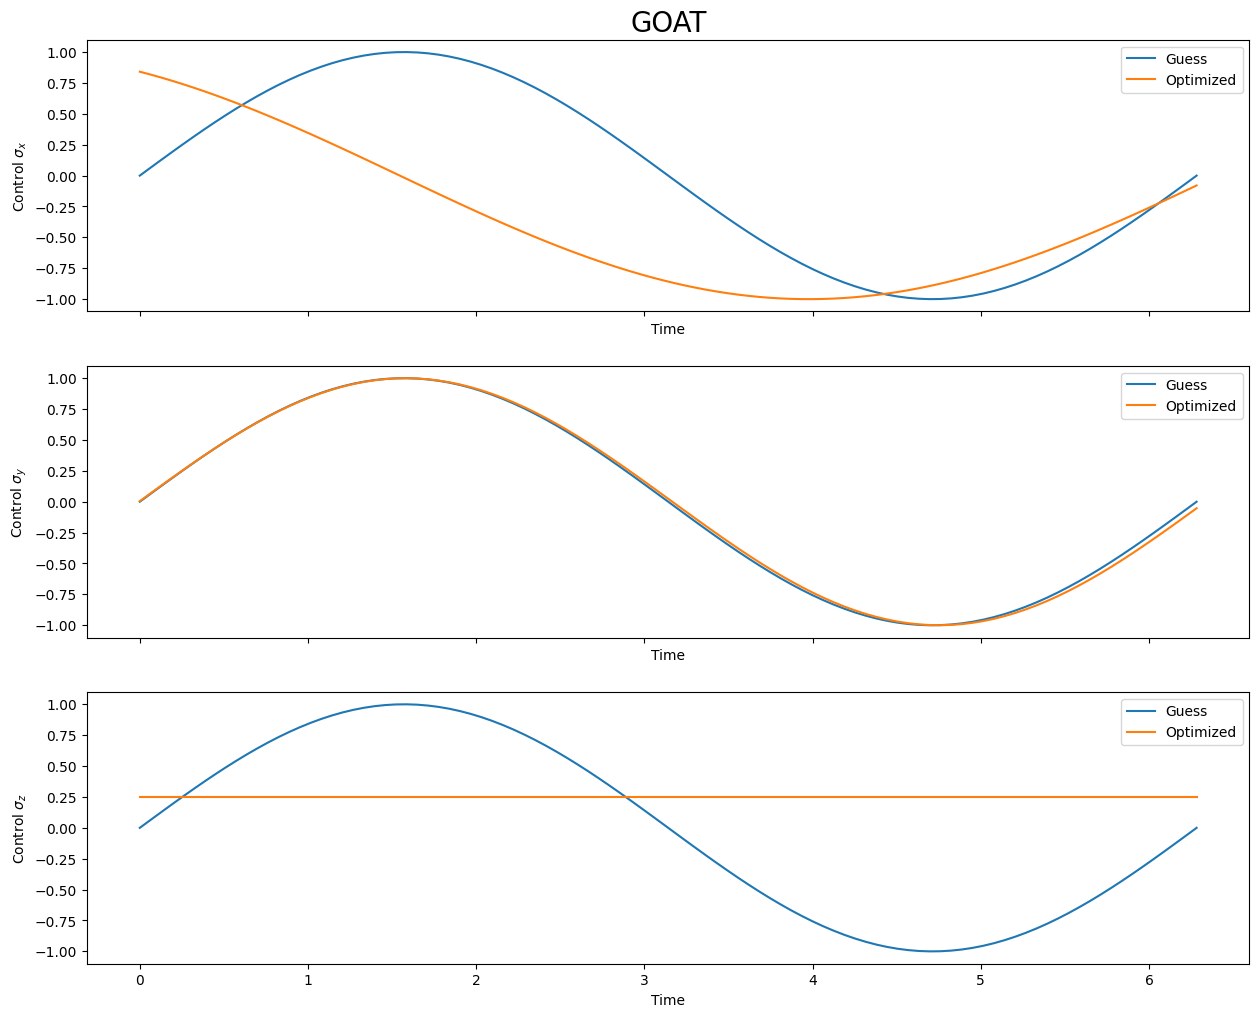

In [21]:
plot_result(res_goat, "GOAT")

# QuTiP JAX

In [22]:
def sin_jax(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

In [23]:
@jax.jit
def sin_x_jax(t, p, **kwargs):
    return sin_jax(t, p)


@jax.jit
def sin_y_jax(t, q, **kwargs):
    return sin_jax(t, q)


@jax.jit
def sin_z_jax(t, r, **kwargs):
    return sin_jax(t, r)

In [24]:
H_jax = [H_d,
         [H_c[0], sin_x_jax],
         [H_c[1], sin_y_jax],
         [H_c[2], sin_z_jax]]

In [25]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "JOAT",  # new
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    }
)

{'bounds': array([[-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531]])}


In [26]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-11-17 15:54:14
- Number of objectives: 1
- Final fidelity error: 0.04695324121353691
- Final parameters: [[0.8470163296123042, 0.9526286114641229, 1.236939011689048], [0.9713650535210567, 0.2934218880155067, 2.6900655450102233], [0.9875030050513052, 0.20866340333994815, 1.9334102158601876]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-17 15:54:23 (8.3403s)

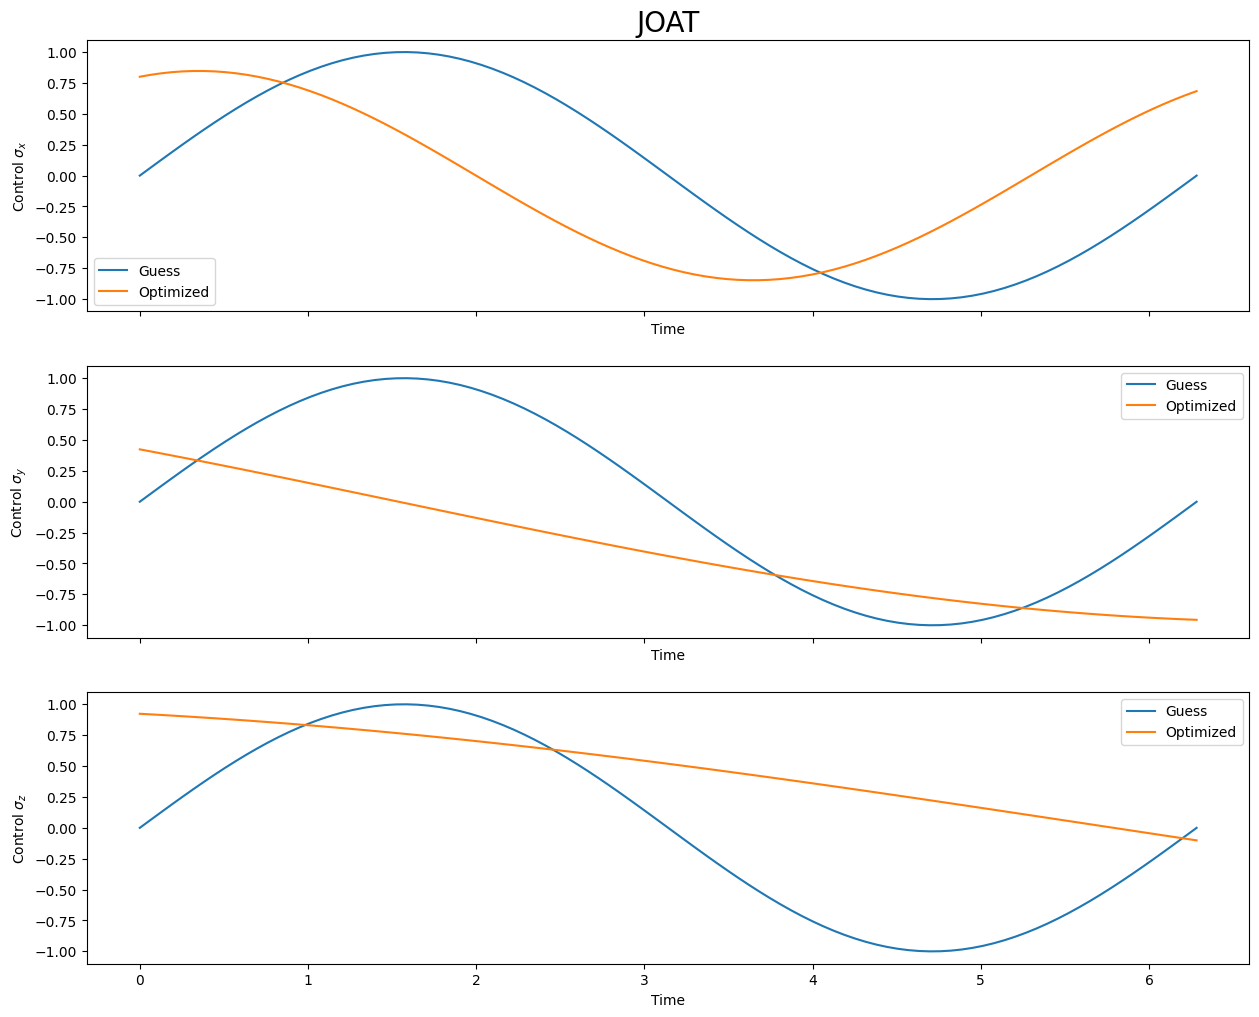

In [27]:
plot_result(res_joat, "JOAT")

# Time Optimization

In [28]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    time_options={  # new
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    # minimizer_kwargs={},
    integrator_kwargs={  # only for comparison
        "atol": 1e-5,
        "rtol": 1e-5,
        "method": "dop853",
    },
)

{'bounds': array([[-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  6.28318531]])}


ValueError: The number of bounds is not compatible with the length of `x0`.

In [ ]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-17 15:06:54
- Number of objectives: 1
- Final fidelity error: 0.04412291127034217
- Final parameters: [[0.9256411608088849, 1.0, 0.11852355874990737], [1.0, 0.605494245168869, 1.7620141961933997], [1.0, 0.8963039531942958, 0.5314531234324357], [5.834237365545289]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-17 15:06:54 (0.6332s)

In [38]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 10 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    integrator_kwargs={  # only for comparison
        "stepsize_controller": PIDController(
            atol=1e-5,
            rtol=1e-5,
        ),
        "solver": Dopri8(),
    },
)

ValueError: The number of bounds is not compatible with the length of `x0`.

In [ ]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-11-16 17:34:44
- Number of objectives: 1
- Final fidelity error: 0.043686306540419585
- Final parameters: [[0.9850728105107782, 1.0, 0.18548992049992452], [1.0, 0.5248719950569659, 2.021511577791485], [1.0, 0.892626336695408, 0.551912242955354], [5.7578927260720345]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-16 17:34:51 (6.9734s)

# Scale-up

In [ ]:
N = 2  # number of qubits

initial = qt.tensor([qt.qeye(2)] * N)
target = qt.tensor([hadamard()] * N)

initial = qt.sprepost(initial, initial.dag())
target = qt.sprepost(target, target.dag())

In [29]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

ω, Δ, γ, π = 0.1, 1.0, 0.1, np.pi

Hd = 1 / 2 * (ω * σz + Δ * σx)

H_d = qt.liouvillian(H=qt.tensor([Hd] * N),
                     c_ops=[np.sqrt(γ) * qt.tensor([qt.sigmam()] * N)])

NameError: name 'N' is not defined

\begin{align*}
    c(t,\vec \alpha) = \sum_{l=0}^{\mathrm{n_{sup}-1}} a_l \sin ( \omega_l t + \phi_l )
\end{align*}

In [ ]:
n_sup = 3
n_var = 3
n_tot = n_sup * n_var

interval = TimeInterval(evo_time=2 * π, n_tslots=1000)

In [35]:
from cy_pulse import SinPulse

sin = SinPulse(n_sup, n_var)

ModuleNotFoundError: No module named 'cy_pulse'

In [ ]:
Hc = []
id = [qt.qeye(2) for _ in range(N)]

for i in range(N):  # 3N controls
    sx, sy, sz = id.copy(), id.copy(), id.copy()
    sx[i], sy[i], sz[i] = σx, σy, σz
    Hc.append(qt.tensor(sx))
    Hc.append(qt.tensor(sy))
    Hc.append(qt.tensor(sz))

H_c = [qt.liouvillian(H) for H in Hc]

H = [H_d] + [[hc, sin.gen_pulse, {"grad": sin.gen_grad}] for hc in H_c]

In [ ]:
p_init = np.ones(n_tot)

In [ ]:
def sin_(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])


pulse_vmap = jax.vmap(sin_, in_axes=(None, 0))


@jax.jit
def sin_jax(t, α):
    alpha = jnp.reshape(α, (n_sup, n_var))
    return jnp.sum(pulse_vmap(t, alpha), axis=0)

In [ ]:
H_jax = [H_d] + [[hc, sin_jax] for hc in H_c]

In [ ]:
p_options = {}
for p in range(len(H_c)):
    p_options[p] = {
        "guess": 0.1 * np.ones(n_tot),
        "bounds": [(-2 * π, 2 * π) for _ in range(n_tot)],
    }

# JOAT

In [ ]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "disp": True,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    integrator_kwargs={
        "stepsize_controller": PIDController(
            atol=1e-5,
            rtol=1e-5,
        ),
        "solver": Dopri5(),
    },
)

minimizer step, infidelity: 0.52866
minimizer step, infidelity: 0.52099
minimizer step, infidelity: 0.51225
minimizer step, infidelity: 0.47795
minimizer step, infidelity: 0.47428
minimizer step, infidelity: 0.45269
minimizer step, infidelity: 0.41762
minimizer step, infidelity: 0.40199
minimizer step, infidelity: 0.39692
minimizer step, infidelity: 0.37773
minimizer step, infidelity: 0.33456
minimizer step, infidelity: 0.32963
minimizer step, infidelity: 0.31794
minimizer step, infidelity: 0.30544
minimizer step, infidelity: 0.29412
minimizer step, infidelity: 0.27863
minimizer step, infidelity: 0.25302
minimizer step, infidelity: 0.23957
minimizer step, infidelity: 0.23133
minimizer step, infidelity: 0.22707
minimizer step, infidelity: 0.22563
minimizer step, infidelity: 0.22554
minimizer step, infidelity: 0.22552
minimizer step, infidelity: 0.22549
minimizer step, infidelity: 0.22541
minimizer step, infidelity: 0.22531
minimizer step, infidelity: 0.22522
minimizer step, infidelity: 

In [ ]:
res_joat

Control Optimization Result
 --------------------------
 - Started at 2023-11-16 17:34:56
 - Number of objectives: 1
 - Final fidelity error: 0.22481405733013268
 - Final parameters: [array([-0.0017651 , -0.00564175, -0.23206423, -0.0017651 , -0.00564175,
-0.23206423, -0.0017651 , -0.00564175, -0.23206423]), array([-1.49522621,  0.02018952, -0.06317116, -1.49522621,  0.02018952,
-0.06317116, -1.49522621,  0.02018952, -0.06317116]), array([-0.00312236, -0.01531084,  0.18024241, -0.00312236, -0.01531084,
 0.18024241, -0.00312236, -0.01531084,  0.18024241]), array([ 0.00065466, -0.23391443, -0.18011778,  0.00065466, -0.23391443,
-0.18011778,  0.00065466, -0.23391443, -0.18011778]), array([-1.57861012,  0.01952405, -0.05931335, -1.57861012,  0.01952405,
-0.05931335, -1.57861012,  0.01952405, -0.05931335]), array([ 0.00166307, -0.57783171, -0.02972519,  0.00166307, -0.57783171,
-0.02972519,  0.00166307, -0.57783171, -0.02972519]), [6.0464186884179325]]
 - Number of iterations: 1
 - Reason f

# GOAT

In [ ]:
print("system size:", H[0].shape[0])
print("number parameters:", n_tot)
print("number of controls:", len(H) - 1)
print("matrix size:", (1 + n_tot * (len(H) - 1)) * H[0].shape[0])

system size: 16
number parameters: 9
number of controls: 6
matrix size: 880


In [ ]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "disp": True,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    integrator_kwargs={
        "atol": 1e-5,
        "rtol": 1e-5,
        "method": "lsoda",
    },
)

minimizer step, infidelity: 0.52867
minimizer step, infidelity: 0.52100
minimizer step, infidelity: 0.51226
minimizer step, infidelity: 0.47786
minimizer step, infidelity: 0.47420
minimizer step, infidelity: 0.45267
minimizer step, infidelity: 0.41765
minimizer step, infidelity: 0.40197
minimizer step, infidelity: 0.39692
minimizer step, infidelity: 0.37774
minimizer step, infidelity: 0.33408
minimizer step, infidelity: 0.32732
minimizer step, infidelity: 0.31865
minimizer step, infidelity: 0.29760
minimizer step, infidelity: 0.28568
minimizer step, infidelity: 0.27512
minimizer step, infidelity: 0.25021
minimizer step, infidelity: 0.23706
minimizer step, infidelity: 0.22877
minimizer step, infidelity: 0.22642
minimizer step, infidelity: 0.22570
minimizer step, infidelity: 0.22560
minimizer step, infidelity: 0.22556
minimizer step, infidelity: 0.22554
minimizer step, infidelity: 0.22550
minimizer step, infidelity: 0.22542
minimizer step, infidelity: 0.22530
minimizer step, infidelity: 

In [ ]:
res_goat

Control Optimization Result
 --------------------------
 - Started at 2023-11-16 17:35:12
 - Number of objectives: 1
 - Final fidelity error: 0.2248464756755205
 - Final parameters: [array([-0.00139707, -0.08225752, -0.0963631 , -0.00139707, -0.08225752,
-0.0963631 , -0.00139707, -0.08225752, -0.0963631 ]), array([-0.7504959 ,  0.0405071 , -0.12645339, -0.7504959 ,  0.0405071 ,
-0.12645339, -0.7504959 ,  0.0405071 , -0.12645339]), array([-0.00194108,  0.02737028,  0.16732948, -0.00194108,  0.02737028,
 0.16732948, -0.00194108,  0.02737028,  0.16732948]), array([ 0.00124166, -0.08136355, -0.01295366,  0.00124166, -0.08136355,
-0.01295366,  0.00124166, -0.08136355, -0.01295366]), array([-0.8650769 ,  0.03580174, -0.10847179, -0.8650769 ,  0.03580174,
-0.10847179, -0.8650769 ,  0.03580174, -0.10847179]), array([ 0.0012194 , -0.35160215, -0.05662582,  0.0012194 , -0.35160215,
-0.05662582,  0.0012194 , -0.35160215, -0.05662582]), [6.031915339517817]]
 - Number of iterations: 1
 - Reason for

# Global Optimization

# JOAT

In [ ]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "disp": True,
    },
    optimizer_kwargs={
        "method": "basinhopping",  # new
        "max_iter": 10,  # new
        "seed": 1,
    },
    integrator_kwargs={
        "stepsize_controller": PIDController(
            atol=1e-5,
            rtol=1e-5,
        ),
        "solver": Dopri5(),
    },
)

minimizer step, infidelity: 0.52866
minimizer step, infidelity: 0.52099
minimizer step, infidelity: 0.51225
minimizer step, infidelity: 0.47795
minimizer step, infidelity: 0.47428
minimizer step, infidelity: 0.45269
minimizer step, infidelity: 0.41762
minimizer step, infidelity: 0.40199
minimizer step, infidelity: 0.39692
minimizer step, infidelity: 0.37773
minimizer step, infidelity: 0.33456
minimizer step, infidelity: 0.32963
minimizer step, infidelity: 0.31794
minimizer step, infidelity: 0.30544
minimizer step, infidelity: 0.29412
minimizer step, infidelity: 0.27863
minimizer step, infidelity: 0.25302
minimizer step, infidelity: 0.23957
minimizer step, infidelity: 0.23133
minimizer step, infidelity: 0.22707
minimizer step, infidelity: 0.22563
minimizer step, infidelity: 0.22554
minimizer step, infidelity: 0.22552
minimizer step, infidelity: 0.22549
minimizer step, infidelity: 0.22541
minimizer step, infidelity: 0.22531
minimizer step, infidelity: 0.22522
minimizer step, infidelity: 

In [ ]:
res_joat

Control Optimization Result
 --------------------------
 - Started at 2023-11-16 17:47:37
 - Number of objectives: 1
 - Final fidelity error: 0.009687961276866176
 - Final parameters: [array([-2.02059934, -0.39412875,  0.01010009, -2.29674948, -1.62435497,
-0.56903048, -1.76389432,  1.59342839, -0.21883602]), array([-1.35984483,  0.89131231, -0.40164418, -0.959087  ,  0.62730242,
 0.12221481, -0.50659154, -1.06395507, -0.70688925]), array([ 1.20338546, -0.21403319,  0.48246452,  0.97063577, -1.00987636,
 0.17869852,  0.92585124,  2.12577411,  0.70880029]), array([ 1.8585716 , -0.8688657 , -0.11529795, -1.48540894,  1.05616704,
 0.05131151,  1.90195192, -0.68469652,  0.51476039]), array([-4.99451426,  3.3708526 , -0.65008676, -4.83538559,  4.34987122,
-1.37634458, -5.69681533,  3.67689051, -0.82379186]), array([ 1.31822533, -0.53373518, -1.11279567,  4.62336588, -2.83291658,
-0.02945702,  2.907179  , -2.35072327, -1.01179728]), [0.8062157694721689]]
 - Number of iterations: 2
 - Reason 

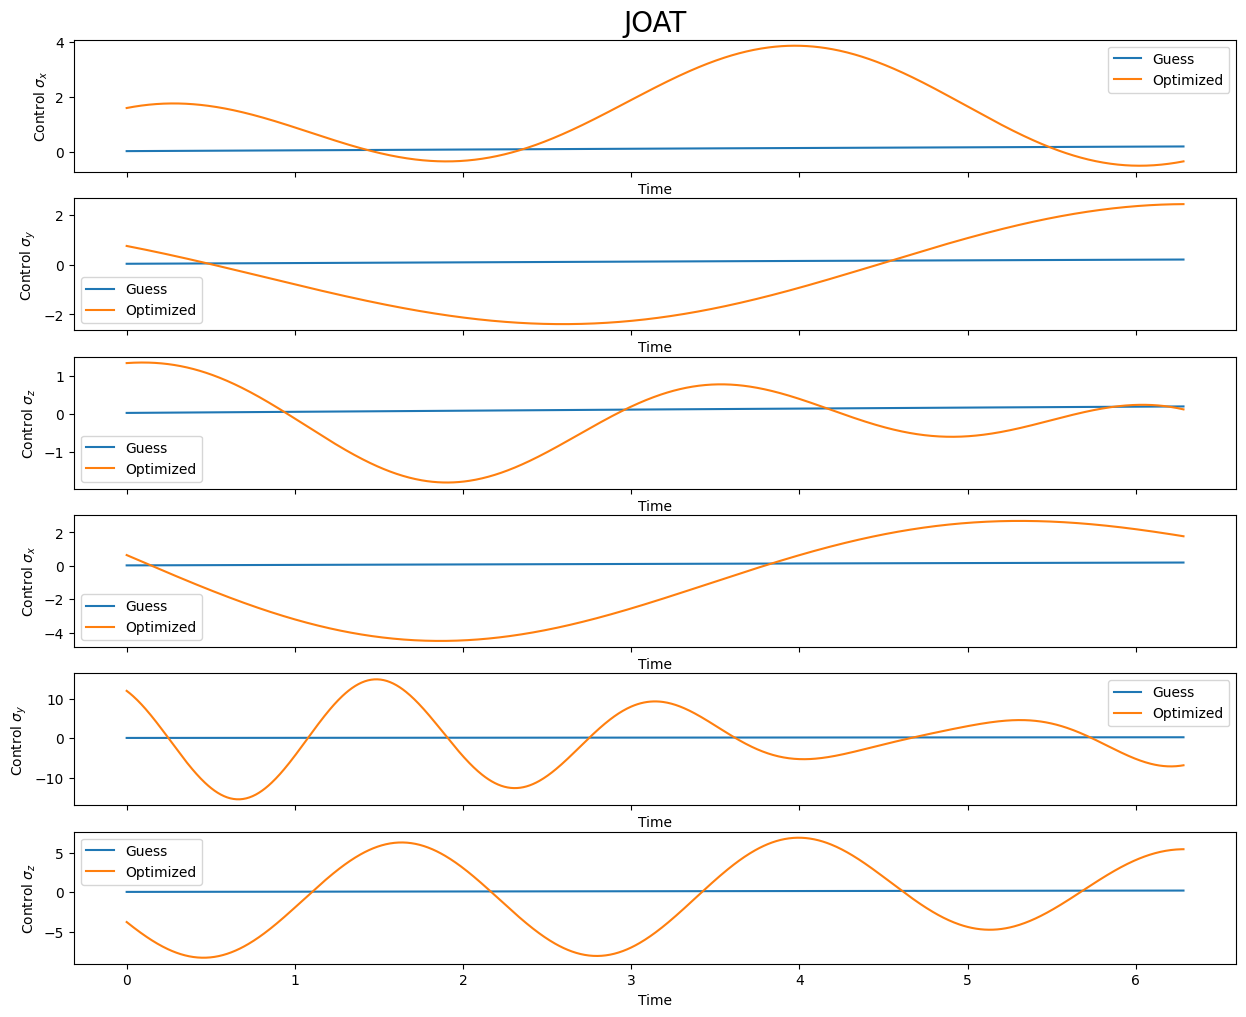

In [ ]:
plot_result(
    res_joat,
    "JOAT",
    y_labels=[
        "$\\sigma_x$",
        "$\\sigma_y$",
        "$\\sigma_z$"] *
    N)